In [19]:
# Import packages

import clustcr
import os
import statsmodels.stats.multitest
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from clustcr import read_cdr3, Clustering
from pyteomics import parser
from scipy.stats import fisher_exact
from skbio.diversity.alpha import shannon, gini_index, pielou_e, simpson

In [20]:
# Read in the correct data files
Data_dir = '/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Raw_data'

Patient_1_pre = pd.read_csv(f'{Data_dir}/HN005_TUMOR_PRE.tsv', sep='\t')
Patient_1_post = pd.read_csv(f'{Data_dir}/HN005_TUMOR_POST.tsv', sep='\t')

Patient_2_pre = pd.read_csv(f'{Data_dir}/HN006_TUMOR_PRE.tsv', sep='\t')
Patient_2_post = pd.read_csv(f'{Data_dir}/HN006_TUMOR_POST.tsv', sep='\t')

Patient_3_pre = pd.read_csv(f'{Data_dir}/HN009_TUMOR_PRE.tsv', sep='\t')
Patient_3_post = pd.read_csv(f'{Data_dir}/HN009_TUMOR_POST.tsv', sep='\t')

# Data preprocessing

In [21]:
# Define parsing functions for all dataframes

# Extract informative columns from large dataframes
def get_columns(data):
    result = data[['aminoAcid','vFamilyName', 'jFamilyName',  'count (templates/reads)']]
    result.rename(columns={'aminoAcid': 'junction_aa', 'count (templates/reads)': 'Frequency_count', 'vFamilyName': 'TRBV_gene', 'jFamilyName': 'TRBJ_gene'}, inplace=True)
    result['Full_CDR3'] = result['junction_aa'] + '_' + result['TRBV_gene'] + '_' + result['TRBJ_gene']
    result = result[~result['Full_CDR3'].isnull()]
    return result


# Define all known amino acids
def is_amino_acid(cdr3):
    return all(aa in parser.std_amino_acids for aa in cdr3)


# Parse data based on CDR3 standards
def parse_data(dataframe):
    Step1 = dataframe[~dataframe['junction_aa'].isnull()]
    Step2 = Step1[Step1['junction_aa'].apply(is_amino_acid)]
    start_c = Step2['junction_aa'].str.startswith('C', na=False)
    end_f = Step2['junction_aa'].str.endswith('F', na=False)
    parse_result = Step2[start_c & end_f].reset_index(drop=True)
    parse_result['Total_freqeuncy'] = parse_result.groupby(['junction_aa','TRBV_gene','TRBJ_gene'])['Frequency_count'].transform('sum')
    parse_result = parse_result[['junction_aa', 'TRBV_gene', 'TRBJ_gene', 'Full_CDR3', 'Total_freqeuncy']]
    parse_result.drop_duplicates(subset=['junction_aa', 'TRBV_gene', 'TRBJ_gene'], inplace=True)
    return parse_result


# Apply column extraction and data parsing on dataframe
def full_parsing(data, patient):
    Columns = get_columns(data)
    Parsing = parse_data(Columns)
    print(f'Parsing: {patient}')
    print(f'The number of TCRs before parsing is: {len(Columns)}')
    print(f'The number of TCRs after parsing is: {len(Parsing)}')
    print(f'The number of TCRs removed is : {len(Columns) - len(Parsing)} \n')
    return Parsing


# Get total number of TCRs per patient
def get_patient_total(data_pre, data_post, Patient):
    data_pre.rename(columns={'Total_freqeuncy': 'Frequency_pre'}, inplace=True)
    data_post.rename(columns={'Total_freqeuncy': 'Frequency_post'}, inplace=True)
    merged = pd.concat([data_pre,data_post]).drop_duplicates(subset='Full_CDR3').reset_index(drop=True)
    print('The total number of unique sequences for', Patient, 'is:', len(merged))
    return merged


# Create the correct file format for clustering of the TCR repertoires
def get_file(dataframe, directory, name):
    result = dataframe[['junction_aa', 'TRBV_gene', 'TRBJ_gene']]
    result.to_csv(f'{directory}/{name}_data.tsv', sep='\t', index=False)
    return result

In [22]:
# Execute parsing steps for each dataset
Data = [Patient_1_pre, Patient_1_post, Patient_2_pre, Patient_2_post, Patient_3_pre, Patient_3_post]
Data_names = ['Patient_1_pre', 'Patient_1_post', 'Patient_2_pre', 'Patient_2_post', 'Patient_3_pre', 'Patient_3_post']
Parsed_frames = []

for i,j in zip(Data,Data_names):
    res = full_parsing(i,j)
    Parsed_frames.append(res)

P1_pre, P1_post, P2_pre, P2_post, P3_pre, P3_post = [pd.DataFrame(j) for j in Parsed_frames]

# Get total number of unique sequences for each patient
Patient1_total = get_patient_total(P1_pre, P1_post, 'Patient 1')
Patient2_total = get_patient_total(P2_pre, P2_post, 'Patient 2')
Patient3_total = get_patient_total(P3_pre, P3_post, 'Patient 3')

Parsing: Patient_1_pre
The number of TCRs before parsing is: 16184
The number of TCRs after parsing is: 15074
The number of TCRs removed is : 1110 

Parsing: Patient_1_post
The number of TCRs before parsing is: 2976
The number of TCRs after parsing is: 2720
The number of TCRs removed is : 256 

Parsing: Patient_2_pre
The number of TCRs before parsing is: 19795
The number of TCRs after parsing is: 17976
The number of TCRs removed is : 1819 

Parsing: Patient_2_post
The number of TCRs before parsing is: 43866
The number of TCRs after parsing is: 39808
The number of TCRs removed is : 4058 

Parsing: Patient_3_pre
The number of TCRs before parsing is: 12050
The number of TCRs after parsing is: 11584
The number of TCRs removed is : 466 

Parsing: Patient_3_post
The number of TCRs before parsing is: 48822
The number of TCRs after parsing is: 46629
The number of TCRs removed is : 2193 

The total number of unique sequences for Patient 1 is: 16228
The total number of unique sequences for Patie

In [24]:
# Get the TCRex format files necessary for clustering with ClusTCR
Dataframes = [P1_pre, P1_post, P2_pre, P2_post, P3_pre, P3_post]
Names=['P1_pre', 'P1_post', 'P2_pre', 'P2_post', 'P3_pre', 'P3_post']
Processed_dir='/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Processed_data'

for i,j in zip(Dataframes, Names):
    get_file(i, Processed_dir, j)

# Repertoire richness and overlap

In [25]:
# Define Jaccard and Morisita repertoire ovelap calculations

def get_repertoire_overlap(data_pre, data_post):
    overlap = data_pre.merge(data_post, how='inner', on=['Full_CDR3'])
    return len(overlap)


def get_jaccard_index(data_pre, data_post):
    Cij = len(data_pre.merge(data_post, how='inner', on=['Full_CDR3']))
    Ni = len(data_pre)
    Nj = len(data_post)
    Jaccard = (Cij)/(Ni+Nj-Cij)
    return Jaccard


def get_morisita_index():
    All_TCRs = pd.concat([P1_pre, P1_post]).drop_duplicates(subset=['Full_CDR3'])
    for i in All_TCRs['Full_CDR3']:
        N1i = (P1_pre.loc[P1_pre['Full_CDR3'] == i])['Total_freqeuncy']
        N2i = (P1_post.loc[P1_post['Full_CDR3'] == i])['Total_freqeuncy']
        A = N1i*N2i
    return 'help'


def get_public_clones(Patient1, Patient2, Patient3):
    public = pd.merge(pd.merge(Patient1,Patient2,on='Full_CDR3'),Patient3,on='Full_CDR3')
    print('The number of public TCRs is:', len(public))
    return public
    

In [26]:
# Calculate Jaccard and Morisita index per patient
Repertoires_pre = [P1_pre, P2_pre, P3_pre]
Repertoires_post = [P1_post, P2_post, P3_post]
Patient_names = ['Patient 1', 'Patient 2', 'Patient 3']

for a,b,c in zip (Repertoires_pre, Repertoires_post, Patient_names):
    # Get overlap size
    Overlap = get_repertoire_overlap(a,b)
    print('\nCalculating for', c, ':')
    print('The overlap between pre and post is', Overlap, 'TCRs')

    # Get Jaccard index
    Jaccard = get_jaccard_index(a,b)
    print('The Jaccard index is:', '{:.4f}'.format(Jaccard))


Calculating for Patient 1 :
The overlap between pre and post is 1566 TCRs
The Jaccard index is: 0.0965

Calculating for Patient 2 :
The overlap between pre and post is 8015 TCRs
The Jaccard index is: 0.1610

Calculating for Patient 3 :
The overlap between pre and post is 5308 TCRs
The Jaccard index is: 0.1003


In [27]:
# Jaccard metric between different post-treatment repertoires
Repertoires_pre = [P1_post, P1_post, P2_post]
Repertoires_post = [P2_post, P3_post, P3_post]
Comparison = ['Patient 1 - Patient 2', 'Patient 1 - Patient 3', 'Patient 2 - Patient 3']

for a,b,c in zip (Repertoires_pre, Repertoires_post, Comparison):
    # Get overlap size
    Overlap = get_repertoire_overlap(a,b)
    print('\nCalculating for', c, ':')
    print('The overlap is', Overlap, 'TCRs')

    # Get Jaccard index
    Jaccard = get_jaccard_index(a,b)
    print('The Jaccard index for is:', '{:.4f}'.format(Jaccard))


Calculating for Patient 1 - Patient 2 :
The overlap is 18 TCRs
The Jaccard index for is: 0.0004

Calculating for Patient 1 - Patient 3 :
The overlap is 18 TCRs
The Jaccard index for is: 0.0004

Calculating for Patient 2 - Patient 3 :
The overlap is 200 TCRs
The Jaccard index for is: 0.0023


In [28]:
# Determine public TCR sequences between the three full repertoires
print('Public TCRs in both pre and post TCR repertoires:')
Public_full = get_public_clones(Patient1_total, Patient2_total, Patient3_total)


# Determine public TCR sequences between the post-treatment repertoires
print('\nPublic TCRs in only post-immunotherapy TCR repertoires:')
Public_post = get_public_clones(P1_post, P2_post, P3_post)

Public TCRs in both pre and post TCR repertoires:
The number of public TCRs is: 16

Public TCRs in only post-immunotherapy TCR repertoires:
The number of public TCRs is: 2


# Diversity calculations

### skbio diversity calculation
- Shannon diversity <br>
- Normalized Shannon diversity (Pielou's evenness) <br>
- Simpson and Gini-Simpson diversity <br>
- Gini coefficient <br>

In [30]:
# Calculate all diversity metrics and combine results in a single dataframe
Dataframes = [P1_pre, P1_post, P2_pre, P2_post, P3_pre, P3_post]
Patients = ['P1_pre', 'P1_post', 'P2_pre', 'P2_post', 'P3_pre', 'P3_post']
Df = []

for i, j in zip(Dataframes, Patients):
    Patient_id = j
    i = i.rename(columns={'Frequency_pre': 'Total_freqeuncy', 'Frequency_post': 'Total_freqeuncy'})
    Shannon = shannon(i['Total_freqeuncy'], base=2)
    Pielou = pielou_e(i['Total_freqeuncy'])
    Simpson = simpson(i['Total_freqeuncy'])
    Gini = gini_index(i['Total_freqeuncy'])
    df = pd.DataFrame({
        'Patient_id': [Patient_id],
        'Shannon_index': [Shannon],
        'Pielou_evenness': [Pielou],
        'Gini-Simpson': [Simpson],
        'Gini_index': [Gini]})
    Df.append(df)

Result_df = pd.concat(Df)
Result_df.reset_index(drop=True, inplace=True)
Result_df

,Patient_id,Shannon_index,Pielou_evenness,Gini-Simpson,Gini_index
0,P1_pre,11.236565,0.809564,0.996644,0.715936
1,P1_post,7.902048,0.692592,0.936423,0.730809
2,P2_pre,10.256699,0.725687,0.987401,0.802038
3,P2_post,11.560222,0.756521,0.995896,0.817275
4,P3_pre,12.273467,0.909156,0.998595,0.466271
5,P3_post,11.076526,0.714203,0.995098,0.852803


In [31]:
# Get visual plots depicting the diversity metrics
def get_shannon_plots(dataframe, shannon_index, pielou_index, fig_dir):
    fig, (ax01, ax02) = plt.subplots(1, 2, figsize=(15, 5))
    x = ['Pre-treatment', 'Post-treatment']
    Pat1 = [dataframe.iloc[0,shannon_index], dataframe.iloc[1,shannon_index]]
    Pat2 = [dataframe.iloc[2,shannon_index], dataframe.iloc[3,shannon_index]]
    Pat3 = [dataframe.iloc[4,shannon_index], dataframe.iloc[5,shannon_index]]

    ax01.plot(x, Pat1, linestyle="-", marker="o", label="Patient 1")
    ax01.plot(x, Pat2, linestyle="-", marker="o", label="Patient 2")
    ax01.plot(x, Pat3, linestyle="-", marker="o", label="Patient 3")
    ax01.legend()
    ax01.tick_params(axis='x', labelsize=12)

    Pat1_p = [dataframe.iloc[0,pielou_index], dataframe.iloc[1,pielou_index]]
    Pat2_p = [dataframe.iloc[2,pielou_index], dataframe.iloc[3,pielou_index]]
    Pat3_p = [dataframe.iloc[4,pielou_index], dataframe.iloc[5,pielou_index]]

    ax02.plot(x, Pat1_p, linestyle="-", marker="o", label="Patient 1 normalized")
    ax02.plot(x, Pat2_p, linestyle="-", marker="o", label="Patient 2 normalized")
    ax02.plot(x, Pat3_p, linestyle="-", marker="o", label="Patient 3 normalized")
    ax02.legend()
    ax02.tick_params(axis='x', labelsize=12)

    ax01.set_title('Shannon Diversity', fontsize=15)
    ax02.set_title('Normalized Shannon Diversity (Pielou)', fontsize=15)

    plt.savefig(f'{fig_dir}/Shannon.jpg',bbox_inches='tight',dpi=400)


def get_metric_plots(dataframe, metric_index, title, fig_dir):
    x = ['Pre-treatment', 'Post-treatment']
    Pat1_m = [dataframe.iloc[0,metric_index], dataframe.iloc[1,metric_index]]
    Pat2_m = [dataframe.iloc[2,metric_index], dataframe.iloc[3,metric_index]]
    Pat3_m = [dataframe.iloc[4,metric_index], dataframe.iloc[5,metric_index]]

    plt.plot(x, Pat1_m, linestyle="-", marker="o", label="Patient 1")
    plt.plot(x, Pat2_m, linestyle="-", marker="o", label="Patient 2")
    plt.plot(x, Pat3_m, linestyle="-", marker="o", label="Patient 3")
    plt.title(f'{title} distibutions', fontsize=15)
    plt.ylabel(f'{title} score', fontsize=12)
    plt.legend()

    plt.savefig(f'{fig_dir}/{title}.jpg',bbox_inches='tight',dpi=400)
        


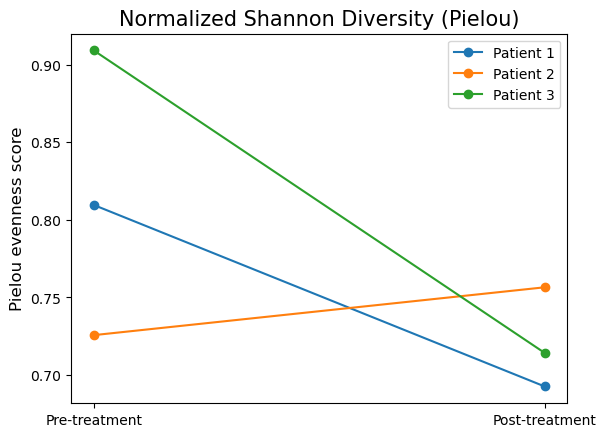

In [32]:
x = ['Pre-treatment', 'Post-treatment']
Pat1 = [Result_df.iloc[0,2], Result_df.iloc[1,2]]
Pat2 = [Result_df.iloc[2,2], Result_df.iloc[3,2]]
Pat3 = [Result_df.iloc[4,2], Result_df.iloc[5,2]]

plt.plot(x, Pat1, linestyle="-", marker="o", label="Patient 1")
plt.plot(x, Pat2, linestyle="-", marker="o", label="Patient 2")
plt.plot(x, Pat3, linestyle="-", marker="o", label="Patient 3")
plt.title(f'Normalized Shannon Diversity (Pielou)', fontsize=15)
plt.ylabel(f'Pielou evenness score', fontsize=12)
plt.legend()

plt.savefig('/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Figures/Pielou.jpg',bbox_inches='tight',dpi=400)

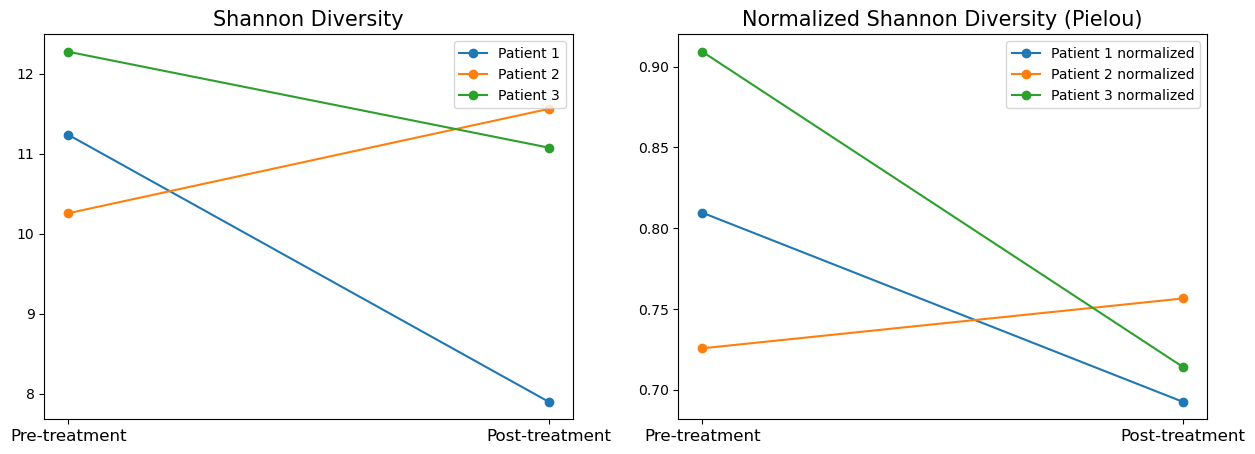

In [33]:
Shannon_plot = get_shannon_plots(Result_df, 1, 2, '/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Figures')

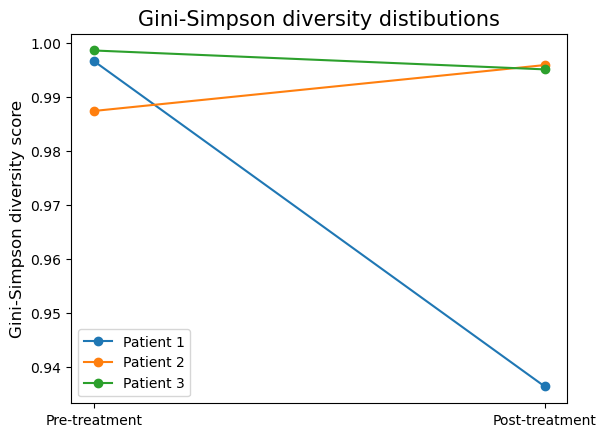

In [34]:
Gini_Simpson_plot = get_metric_plots(Result_df, 3, 'Gini-Simpson diversity', '/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Figures')

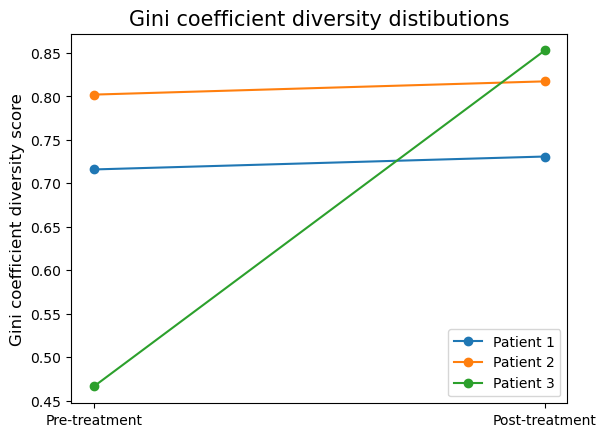

In [35]:
Gini_coefficient_plot = get_metric_plots(Result_df, 4, 'Gini coefficient diversity', '/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Figures')

### Percentile calculation

In [41]:
# Calculate TCRs per percentile

def get_50th_percentile(data):
    data = data.rename(columns={'Frequency_pre': 'Total_freqeuncy', 'Frequency_post': 'Total_freqeuncy'})
    Total = data['Total_freqeuncy'].sum()
    data['Frequency'] = data.apply(lambda row: row.Total_freqeuncy/Total, axis = 1)
    data.sort_values(by='Frequency', ascending=False)
    data['cumulative_sum'] = data['Frequency'].cumsum()
    First_index = data[data.cumulative_sum >= 0.5].index[0]
    Ratio = First_index/len(P1_pre)
    return Ratio


In [44]:
Dataframes = [P1_pre, P1_post, P2_pre, P2_post, P3_pre, P3_post]
Patients = ['P1_pre', 'P1_post', 'P2_pre', 'P2_post', 'P3_pre', 'P3_post']

for i,j in zip(Dataframes,Patients):
    Ratio_50 = get_50th_percentile(i)
    print('The DE50 value for', j, 'is:', '{:.4f}'.format(Ratio_50))

The DE50 value for P1_pre is: 0.0236
The DE50 value for P1_post is: 0.0025
The DE50 value for P2_pre is: 0.0092
The DE50 value for P2_post is: 0.0291
The DE50 value for P3_pre is: 0.1498
The DE50 value for P3_post is: 0.0134


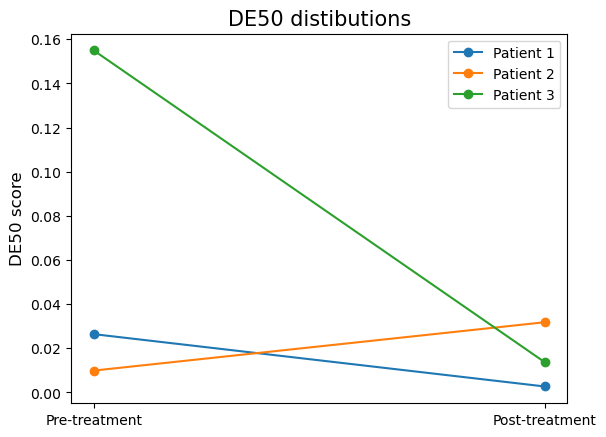

In [45]:
#########################
### DE50 calculations ###
#########################

x = ['Pre-treatment', 'Post-treatment']
Pat1_DE50 = [0.0264, 0.0027]
Pat2_DE50 = [0.0099, 0.0318]
Pat3_DE50 = [0.1549, 0.0137]

plt.plot(x, Pat1_DE50, linestyle="-", marker="o", label="Patient 1")
plt.plot(x, Pat2_DE50, linestyle="-", marker="o", label="Patient 2")
plt.plot(x, Pat3_DE50, linestyle="-", marker="o", label="Patient 3")
plt.title('DE50 distibutions', fontsize=15)
plt.ylabel('DE50 score', fontsize=12)
plt.legend()

plt.savefig("/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Figures/DE50_index.jpg",bbox_inches='tight',dpi=400)

# Analysis of frequency distributions

In [46]:
def get_dataframe(data_post, data_pre):
    dataframe = data_post[['Full_CDR3', 'junction_aa', 'TRBV_gene', 'TRBJ_gene', 'Frequency_post']].merge(data_pre[['junction_aa', 'TRBV_gene', 'TRBJ_gene', 'Frequency_pre']], how='inner', on=['junction_aa', 'TRBV_gene', 'TRBJ_gene'])
    return dataframe

# Make contingencytable for each patient and each CDR3 sequence
def get_fisher_exact(data, CDR3):
    contingency = {"junction_aa":[],"p_value":[],"Odds_Ratio":[]}
    for i,j in zip(range(len(data)), CDR3):
        Pre = data['Frequency_pre'].iloc[i]
        Post = data['Frequency_post'].iloc[i]
        df = data.drop([i])
        rest_pre = df['Frequency_pre'].sum()
        rest_post = df['Frequency_post'].sum()
        # Do the Fisher exact test
        oddsr, p = fisher_exact([[Post, Pre],[rest_post, rest_pre]], alternative="greater")
        contingency["junction_aa"].append(j)
        contingency["p_value"].append(p)
        contingency['Odds_Ratio'].append(oddsr)
    return contingency

# Define Benjamini-Hochberg multiple testing correction
def get_bh_correction(Fisher_res):
    mtc = pd.DataFrame(Fisher_res).sort_values(by="p_value").set_index("junction_aa")
    BH_corr = statsmodels.stats.multitest.fdrcorrection(mtc['p_value'], alpha=0.05, method='indep', is_sorted=False)
    mtc['BH_p_values'] = BH_corr[1]
    mtc = mtc[mtc.BH_p_values<0.05]
    return mtc

# Define full Fisher exact test and multiple testing correction
def Full_fisher_exact(data_post, data_pre):
    Data = get_dataframe(data_post, data_pre)
    CDR3_names = Data['Full_CDR3']
    Fisher_test = get_fisher_exact(Data, CDR3_names)
    Fisher_res = get_bh_correction(Fisher_test)
    return Fisher_res


In [47]:
# Execute Fisher association testing for all three patients.
Fisher_p1 = Full_fisher_exact(P1_post, P1_pre)
Fisher_p2 = Full_fisher_exact(P2_post, P2_pre)
Fisher_p3 = Full_fisher_exact(P3_post, P3_pre)

# Write to file for later use
Fisher_p1.to_csv('/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Processed_data/Fisher_p1.csv')
Fisher_p2.to_csv('/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Processed_data/Fisher_p2.csv')
Fisher_p3.to_csv('/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Processed_data/Fisher_p3.csv')

# See how many significantly increased TCR sequences are discovered per patient.
print('The number of significantly increased CDR3s in patient 1 is:', len(Fisher_p1))
print('The number of significantly increased CDR3s in patient 2 is:', len(Fisher_p2))
print('The number of significantly increased CDR3s in patient 3 is:', len(Fisher_p3))

The number of significantly increased CDR3s in patient 1 is: 48
The number of significantly increased CDR3s in patient 2 is: 751
The number of significantly increased CDR3s in patient 3 is: 113


# Clustering of the repertoires

### Clustering of one TCR repertoire

In [101]:
# Clustering one repertoire
import clustcr
import pandas as pd
from clustcr import read_cdr3, Clustering

# Initiate ClusTCR clustering object
clustering = clustcr.Clustering()

# Import the data
data = read_cdr3(file='/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Processed_data/P2_pre_data.tsv', data_format='tcrex')
print('\nNumber of TCRs in input data is:', len(data))

# Fit data to the clustering object
result = clustering.fit(data)


Number of TCRs in input data is: 17644
Clustering 17644 TCRs using two-step approach.
Total time to run ClusTCR: 2.119s


### Clustering of multiple TCR repertoires

In [102]:
# Without V_gene inclusion
def get_clusters(file_dir, name, Cluster_dir):
    Data = read_cdr3(file=f'{file_dir}/{name}_data.tsv', data_format='tcrex')
    print('\nNumber of TCRs in input data: %s' % (len(Data)))
    # Fit data to clustering object
    clustering = Clustering(n_cpus=8)
    result = clustering.fit(Data)
    Clusters = result.clusters_df
    Summary = result.summary()
    print('The number of clusters for', name, 'is:', len(Summary))
    features = result.compute_features()
    Cl_content = result.cluster_contents()
    Cl_content = pd.DataFrame(Cl_content)
    Clusters.to_csv(f'{Cluster_dir}/{name}_clusters.csv', index=False)
    Summary.to_csv(f'{Cluster_dir}/{name}_summary.csv', index=False)
    features.to_csv(f'{Cluster_dir}/{name}_features.csv', index=False)
    Cl_content.to_csv(f'{Cluster_dir}/{name}_cl_content.csv', index=False)

In [103]:
File_dir = '/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Processed_data'
Cluster_dir = '/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Cluster_results'
Names = ['P1_pre', 'P1_post', 'P2_pre', 'P2_post', 'P3_pre', 'P3_post']

for i in Names:
    get_clusters(File_dir, i, Cluster_dir)


Number of TCRs in input data: 14858
Clustering 14858 TCRs using two-step approach.
Total time to run ClusTCR: 8.248s
The number of clusters for P1_pre is: 639

Number of TCRs in input data: 2695
Clustering 2695 TCRs using two-step approach.
Total time to run ClusTCR: 6.156s
The number of clusters for P1_post is: 81

Number of TCRs in input data: 17644
Clustering 17644 TCRs using two-step approach.
Total time to run ClusTCR: 6.642s
The number of clusters for P2_pre is: 733

Number of TCRs in input data: 38872
Clustering 38872 TCRs using two-step approach.
Total time to run ClusTCR: 9.755s
The number of clusters for P2_post is: 1768

Number of TCRs in input data: 11527
Clustering 11527 TCRs using two-step approach.
Total time to run ClusTCR: 6.340s
The number of clusters for P3_pre is: 455

Number of TCRs in input data: 45790
Clustering 45790 TCRs using two-step approach.
Total time to run ClusTCR: 12.999s
The number of clusters for P3_post is: 2112


In [111]:
def get_shared_clusters(Clusdir, name):
    Summary_pre = pd.read_csv(f'{Clusdir}/{name}_pre_summary.csv')
    Summary_post = pd.read_csv(f'{Clusdir}/{name}_post_summary.csv')
    set1 = set(Summary_pre['motif'])
    set2 = set(Summary_post['motif'])
    Shared = set1.intersection(set2)
    Pre_shared = Summary_pre.loc[Summary_pre['motif'].isin(Shared)]
    Post_shared = Summary_post.loc[Summary_post['motif'].isin(Shared)]
    Pre_shared.rename(columns={'size': 'size_pre'}, inplace=True)
    Post_shared.rename(columns={'size': 'size_post'}, inplace=True)
    Result = Pre_shared.merge(Post_shared, on='motif')
    Result.sort_values(by=['size_post'], ascending=False, inplace=True)
    return Result

In [112]:
All_shared = []
Clusdir='/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Cluster_results'
Names = ['P1', 'P2', 'P3']

for i in Names:
    res = get_shared_clusters(Clusdir, i)
    All_shared.append(res)

Patient1_shared, Patient2_shared, Patient3_shared = [pd.DataFrame(item) for item in All_shared]

print('The number of shared clusters in patient 1 is:', len(Patient1_shared))
print('The number of shared clusters in patient 2 is:', len(Patient2_shared))
print('The number of shared clusters in patient 3 is:', len(Patient3_shared))

The number of shared clusters in patient 1 is: 11
The number of shared clusters in patient 2 is: 40
The number of shared clusters in patient 3 is: 26


In [117]:
Patient2_shared

,size_pre,motif,size_post
0,120,CASS...nTEAFF,192
2,28,CASS..YEQYF,74
3,21,CASS..TGELFF,72
4,9,CASS..GNTIYF,22
6,4,CAISGVSYNEQFF,4
25,4,CASSYRTGGTEAFF,4
31,2,CATSDFG[QT]GPGELFF,2
24,2,CASSL[NL]GPATNEKLFF,2
26,2,CAS[DI]GTSGYNEQFF,2
27,2,CASSPAG[DW]TGELFF,2


# Find significantly increased TCRs in expanded clusters

In [113]:
def get_Fisher_CDR3s(fisher_dir, fisher_name):
    Fisher_data = pd.read_csv(f'{fisher_dir}/{fisher_name}.csv')
    Fisher_data['CDR3'] = Fisher_data['junction_aa'].str.extract(r'(^C.*)_TCRBV.*')

    return Fisher_data

def get_cluster_contents(Clusdir, patient, motif, Fisher_data):
    Summary_pre = pd.read_csv(f'{Clusdir}/{patient}_pre_summary.csv')
    Summary_post = pd.read_csv(f'{Clusdir}/{patient}_post_summary.csv')
    Clusters_pre = pd.read_csv(f'{Clusdir}/{patient}_pre_clusters.csv')
    Clusters_post = pd.read_csv(f'{Clusdir}/{patient}_post_clusters.csv')
    Index_pre = Summary_pre.index[Summary_pre['motif'] == motif].tolist()
    Index_post = Summary_post.index[Summary_post['motif'] == motif].tolist()
    Cluster_pre = Clusters_pre.loc[Clusters_pre['cluster'] == Index_pre[0]]
    Cluster_post = Clusters_post.loc[Clusters_post['cluster'] == Index_post[0]]
    set_fisher = set(Fisher_data['CDR3'])
    set_pre = set(Cluster_pre['junction_aa'])
    set_post = set(Cluster_post['junction_aa'])
    Enriched_TCRs_pre = set_fisher&set_pre
    Enriched_TCRs_post = set_fisher&set_post
    print('The enriched TCRs for', patient, 'pre are:', len(Enriched_TCRs_pre))
    print('The enriched TCRs for', patient, 'post are:', len(Enriched_TCRs_post))

    return Enriched_TCRs_pre, Enriched_TCRs_post

def find_enriched_TCRs(fisher_dir, fisher_name, Clusdir, patient, motif):
    Fisher_dataframe = get_Fisher_CDR3s(fisher_dir, fisher_name)
    Enriched_clusters = get_cluster_contents(Clusdir, patient, motif, Fisher_dataframe)
    Enriched_pre = Enriched_clusters[0]
    Enriched_post = Enriched_clusters[1]
    Unique_elements = Enriched_post - Enriched_pre
    All_enriched = list(Enriched_pre) + list(Unique_elements)
    print('The number of enriched TCRs for cluster', motif, 'in', patient, 'is:', len(All_enriched))

    return All_enriched

In [114]:
Motifs = ['CASS...nTEAFF', 'CASS..YEQYF', 'CASS..TGELFF', 'CASS..GNTIYF']

for i in Motifs:
    Fisher_dir = '/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Processed_data'
    Fisher_name = 'Fisher_p2'
    Clusdir = '/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Cluster_results'
    Patient = 'P2'
    Full_enriched_clusters = find_enriched_TCRs(Fisher_dir, Fisher_name, Clusdir, Patient, i)
    print(Full_enriched_clusters)

The enriched TCRs for P2 pre are: 9
The enriched TCRs for P2 post are: 9
The number of enriched TCRs for cluster CASS...nTEAFF in P2 is: 13
['CASSLWRNTEAFF', 'CASSLALNTEAFF', 'CASSFVGGTEAFF', 'CASSSRGNTEAFF', 'CASSLHTNTEAFF', 'CASSLALDTEAFF', 'CASSRGRDTEAFF', 'CASRWTGGTEAFF', 'CASSLEGATEAFF', 'CASSFRTDTEAFF', 'CASSFRGDTEAFF', 'CASRPQLNTEAFF', 'CASSPDRNTEAFF']
The enriched TCRs for P2 pre are: 4
The enriched TCRs for P2 post are: 5
The number of enriched TCRs for cluster CASS..YEQYF in P2 is: 5
['CASSSSYEQYF', 'CASSTSYEQYF', 'CASSLSYEQYF', 'CASSDGYEQYF', 'CASRATYEQYF']
The enriched TCRs for P2 pre are: 2
The enriched TCRs for P2 post are: 2
The number of enriched TCRs for cluster CASS..TGELFF in P2 is: 2
['CASSLPTGELFF', 'CASSARTGELFF']
The enriched TCRs for P2 pre are: 1
The enriched TCRs for P2 post are: 1
The number of enriched TCRs for cluster CASS..GNTIYF in P2 is: 1
['CASSLSGNTIYF']


In [116]:
Data = pd.read_csv('/Users/romivandoren/Desktop/Romi/Adrem/PhD/MCB_chapter/Chapter_final/Processed_data/Fisher_p2.csv')
Data['CDR3'] = Data['junction_aa'].str.extract(r'(^C.*)_TCRBV.*')

Data.loc[Data['CDR3'] == 'CASSLWRNTEAFF']

,junction_aa,p_value,Odds_Ratio,BH_p_values,CDR3
13,CASSLWRNTEAFF_TCRBV07_TCRBJ01,1.244064e-149,88.720819,7.122269e-147,CASSLWRNTEAFF
